[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 6.2 Isolated Word Recognition from audio using RNNs

In this exercise we build a small vocabulary isolated spoken word recogniser using a recurrent network classifier.

The data is a subset of the [Google Speech Commands](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) corpus.

A similar tutorial that features Tensorflow's audio processing capabilities is [here](https://www.tensorflow.org/tutorials/audio/simple_audio).


---
Import the usual libraries and the [`librosa` package](https://librosa.org/) which we will use for most of the audio processing tasks. And some utilities.

The following code will also ask for **permission to save files to your Google Drive**. We will use this to save processed speech data to save time when opening the notebook in future.

In [ ]:
!pip -q install pydub
from pydub import AudioSegment

import time
from os import path
from io import BytesIO
from base64 import b64decode
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.util
import librosa.display

from IPython.display import HTML, display, Audio, Javascript
from google.colab import drive, output
#drive.mount("/content/gdrive")

# Some functions we will use in this notebook (details not too important here)
def librosa_load_url(url, sr=16000):
  return librosa.load(BytesIO(urlopen(url).read()), sr=sr)

def znorm(X, means, stds):
  return (X - means) / stds

# Ignore the following HTML and Javascript code (we simply use it later)
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


---
The "mini speech commands" corpus has already been uncompressed and stored on the PALS0039 site [here](https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_06/mini_speech_commands/). By following the link you will see that the audio files are organised in sub-folders of recordings for each word.

Let's load and listen to some of them:

In [ ]:
corpus_folder = "https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_06/mini_speech_commands/"
print("DOWN:")
Audio(path.join(corpus_folder, "down", "004ae714_nohash_0.flac"))

DOWN:


---
Let's visualise one of the recordings, including the [*oscillogram*](https://en.wikipedia.org/wiki/Waveform), [*spectrogram*](https://en.wikipedia.org/wiki/Spectrogram) and [*mel-frequency cepstral coefficients*](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCCs) using `librosa` and `matplotlib`:

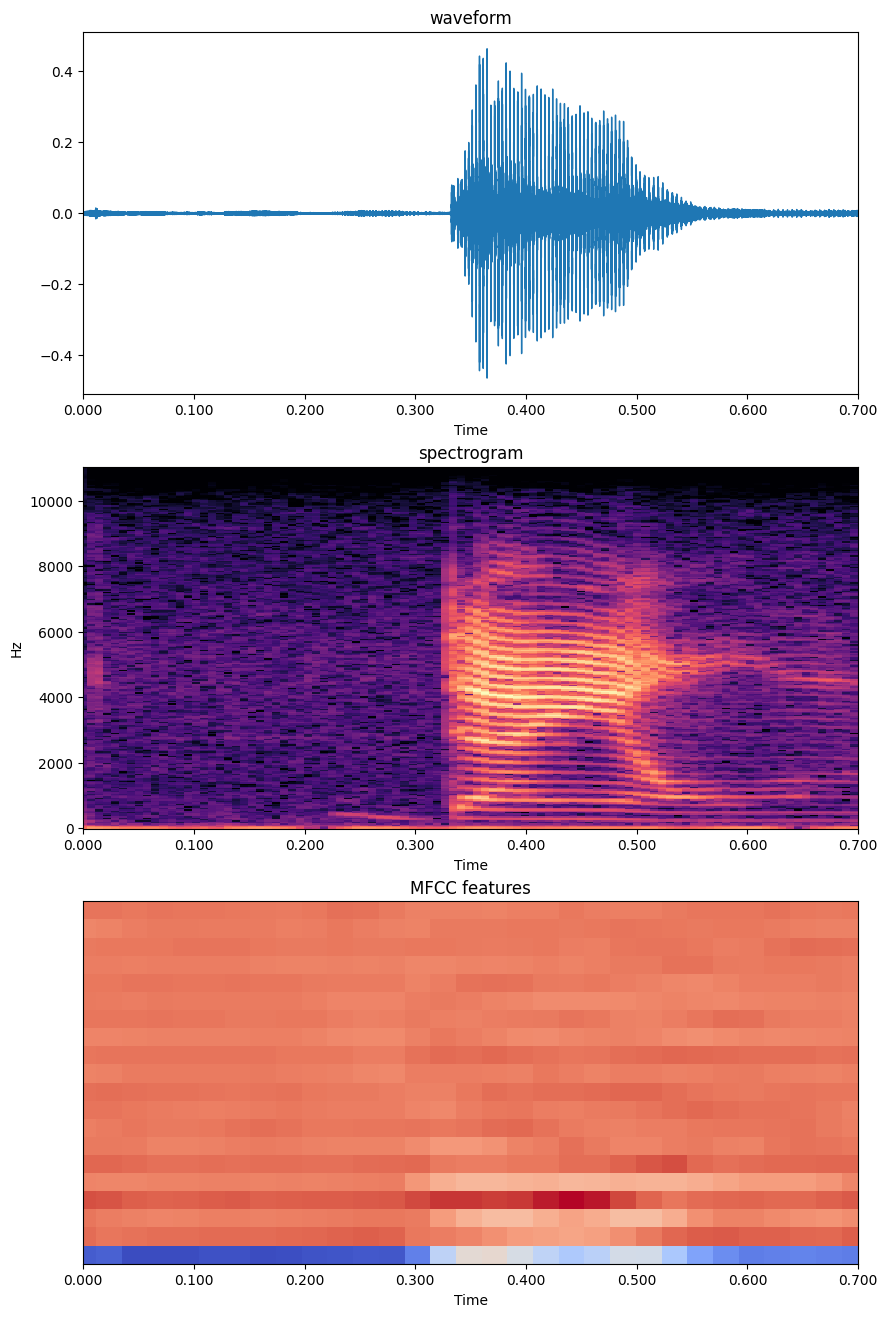

In [ ]:
def plot_audio(audio, sample_rate=16000, xlim=[0.0, 1.0]):
  # No added measurement units for x and y axes! seconds for time and amplitude
  fig, axs = plt.subplots(3, 1, figsize=(10, 16))
  librosa.display.waveshow(audio, ax=axs[0])
  D = librosa.stft(audio, n_fft=512, hop_length=160)
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  librosa.display.specshow(S_db, x_axis='time', y_axis='linear', hop_length=160, ax=axs[1])
  # MFCC is frequency on mel-frequency scale (spectrum of the spectrum)
  # Condenses num of features for ML
  mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate)
  librosa.display.specshow(mfcc_features, x_axis='time', ax=axs[2])
  for ax, title in zip(axs, ["waveform", "spectrogram", "MFCC features"]):
    ax.set_xlim(xlim)
    ax.set_title(title)

example_audio, sample_rate = librosa_load_url(path.join(corpus_folder, "down", "004ae714_nohash_0.flac"))
plot_audio(example_audio, sample_rate, xlim=[0.0, 0.7])
plt.show()

---
The audio files have already been partitioned and randomized into train and test sets -- the file lists are also on the PALS0039 server. The next section implements the following:
- Creates numpy arrays to contain the audio features and one-hot encoded labels
- Loads each file and uses `librosa` to perform feature extraction (we use MFCCs as shown in the third sub-plot above)

In [ ]:
import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")


corpus_folder = "https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_06/mini_speech_commands/"
words = ["yes", "no", "up", "down", "left", "right", "stop", "go"]
wordsmap = {w: i for i, w in enumerate(words)}
wordsmap_inv = {v: k for k, v in wordsmap.items()}


# Our feature extraction function which expectes 16kHz audio
# and produces MFCCs padded/truncated to a length of 1 second
def extract_features(audio, n_mfcc=20, hop_length=160, maxseq_length=100):
  mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc, hop_length=hop_length)
  padded_mfccs =  librosa.util.fix_length(mfccs, size=maxseq_length, axis=1)
  return padded_mfccs


# The maximum length of audio files in the corpus is 1 second (sample rate of 16kHz).
# We will be extracting 20 MFCC features every 10 ms (160 audio samples).
# This means that the maximum length of our sequences of features will be: 1000 ms / 10 ms == 100.
def prepare_data(filelist, folder=corpus_folder, maxseq_length=100, n_mfcc=20, word_mapping=wordsmap):

  # Create empty arrays of the right sizes to contain the processed data
  X = np.zeros((len(filelist), maxseq_length, n_mfcc))
  labels = np.zeros((len(filelist)), dtype=int)

  # Go through the list of files, process each one, and place in the arrays:
  progress_bar = display(progress(0, len(filelist)), display_id=True)
  for i, filepath in enumerate(filelist):
    filepath = str(filepath, encoding="utf-8")
    progress_bar.update(progress(i+1, len(filelist)))

    # The first part of the filepath contains the sub-folder which indicates the word
    word = filepath.split("/")[0]
    # Place the integer representation in `labels`
    labels[i] = word_mapping[word]

    # Load audio file from URL
    audio, sr = librosa_load_url(path.join(folder, filepath))
    assert sr == 16000
    # Extract MFCCs and pad/truncate them to length 100
    padded_mfccs = extract_features(audio, n_mfcc, maxseq_length=maxseq_length)
    # Transpose and place MFCCs in `X`
    X[i] = padded_mfccs.T

  # Convert labels to one-hot encoding and return the data
  y = to_categorical(labels)
  return X, y


Using GPU device


---
Next we fetch the file lists, actually run the above code and save the processed data to files in Google Drive.

**Note**: This is a slow process which *may take up to an hour or more to complete*. It should only be done once. If you need to rerun or continue this notebook again later, just reload the processed data which was saved to Google Drive.

In [ ]:
import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

# Get the lists of train and test files from the PALS server
trainfiles = urlopen(path.join(corpus_folder, "train_files.txt")).read().split()
testfiles = urlopen(path.join(corpus_folder, "test_files.txt")).read().split()

# Load and process the files
print("Loading train data:")
Xtrain, ytrain = prepare_data(trainfiles)
print("Loading test data:")
Xtest, ytest = prepare_data(testfiles)

# Save the processed data to Google Drive
np.save("/content/gdrive/My Drive/PALS0039_Ex62_Xtrain.npy", Xtrain)
np.save("/content/gdrive/My Drive/PALS0039_Ex62_ytrain.npy", ytrain)
np.save("/content/gdrive/My Drive/PALS0039_Ex62_Xtest.npy", Xtest)
np.save("/content/gdrive/My Drive/PALS0039_Ex62_ytest.npy", ytest)

Using GPU device
Loading train data:


Loading test data:


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/PALS0039_Ex62_Xtrain.npy'

---
Load the saved data from Google Drive. If you pick up the notebook later on, run all the code fragments **except the last one** and then continue from here.

In [ ]:
Xtrain = np.load("/content/gdrive/My Drive/PALS0039_Ex62_Xtrain.npy")
ytrain = np.load("/content/gdrive/My Drive/PALS0039_Ex62_ytrain.npy")
Xtest = np.load("/content/gdrive/My Drive/PALS0039_Ex62_Xtest.npy")
ytest = np.load("/content/gdrive/My Drive/PALS0039_Ex62_ytest.npy")

---
Normalise the input features and inspect the train and test data set sizes. We confirm that the training set consists of 7200 speech samples of length 100 frames each, with each frame consisting of 20 values (MFCCs). The output has 8 columns which is the vocabulary size. Similarly for the test set, but here we have 800 samples.

In [ ]:
train_means = Xtrain.mean(0)
train_stds = Xtrain.std(0)

Xtrain_norm = znorm(Xtrain, train_means, train_stds)
Xtest_norm = znorm(Xtest, train_means, train_stds)

print("Xtrain shape:", Xtrain_norm.shape)
print("ytrain shape:", ytrain.shape)
print("Xtest shape:", Xtest_norm.shape)
print("ytest shape:", ytest.shape)

Xtrain shape: (7200, 100, 20)
ytrain shape: (7200, 8)
Xtest shape: (800, 100, 20)
ytest shape: (800, 8)


---
Build a model

In [ ]:
def build_model(input_shape=Xtrain.shape[1:], output_width=ytrain.shape[1], batch_size=32, hidden_width=32, dropout_rate=0.2, learning_rate=0.01):
  model = Sequential()
  # Biderectional two-way LSTM, wrapped around LSTM network, only possible when we know future input!
  # return_sequences, usually set to False = return all outputs (because we are passing them onto next layer)
  model.add(Bidirectional(LSTM(hidden_width, return_sequences=True, input_shape=input_shape)))
  # During training, randomly discard 20% of units/nodes to make it more robust, only during pre-training
  model.add(Dropout(dropout_rate))
  # More layers captures more non-linear interactions (abstraction towards probability)
  model.add(Bidirectional(LSTM(hidden_width)))
  model.add(Dropout(dropout_rate))
  # (FNN) Dense layer takes 32-units of LSTM and at each time-step connects it to 32-other units, no info from past, can transform abstract outputs in some way
  model.add(Dense(hidden_width))
  # Add layers that go towards dimension of our output (32, 16, 8)
  model.add(Dense(16))
  model.add(Dense(output_width, activation="softmax"))
  # Multi-class classification = categorical_crossentropy, Adam optimiser (current state-of-the-art)
  model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])
  model.build(input_shape=(batch_size, *input_shape))
  return model

# Smaller batch sizes = more learning updates
# Overfitting, try higher hidden_width?
# Learning rate typically 0.0001, so we have quite a high learning rate. Problematic for gradient descent, overshooting global minimum

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (32, 100, 64)               │          13,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 100, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (32, 64)                    │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 32)                    │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 16)                    │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 8)                     │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,144 (160.72 KB)

 Trainable params: 41,144 (160.72 KB)

 Non-trainable params: 0 (0.00 B)

(a) Call the [`model.fit` method](https://keras.io/api/models/model_training_apis/#fit-method) with the correct arguments to train the model with the following specifications: (1) Train for 30 iterations over the dataset; (2) Update the weights during training in batches of 32 samples; (3) Request Keras to randomly select 10% of the training set as the validation set. (4) Implement early stopping if the validation set loss does not decrease for 10 epochs.

In [ ]:
#(a)
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

# Setting patience is important, nit too short, not too long, difficult param to set?
# Set verbose to 0 in assessment!
training_info = model.fit(Xtrain_norm, ytrain, epochs=30, batch_size=32, validation_split=0.1, callbacks=EarlyStopping(monitor='val_loss', patience=10))

Using GPU device
Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2635 - loss: 1.9068 - val_accuracy: 0.3917 - val_loss: 1.5880
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4236 - loss: 1.5371 - val_accuracy: 0.5639 - val_loss: 1.1751
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5285 - loss: 1.2788 - val_accuracy: 0.6653 - val_loss: 0.9498
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6708 - loss: 0.9477 - val_accuracy: 0.7639 - val_loss: 0.7521
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7411 - loss: 0.7492 - val_accuracy: 0.7514 - val_loss: 0.7297
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7777 - loss: 0.6726 - val_accuracy: 0.7667 - val_loss: 0.7072
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7852 - loss: 0.6209 - val_accuracy: 0.7903 - val_loss: 0.6420
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8019 - loss:

---
Plot and examine the training graphs, compare the training and evaluation errors. Run the code.

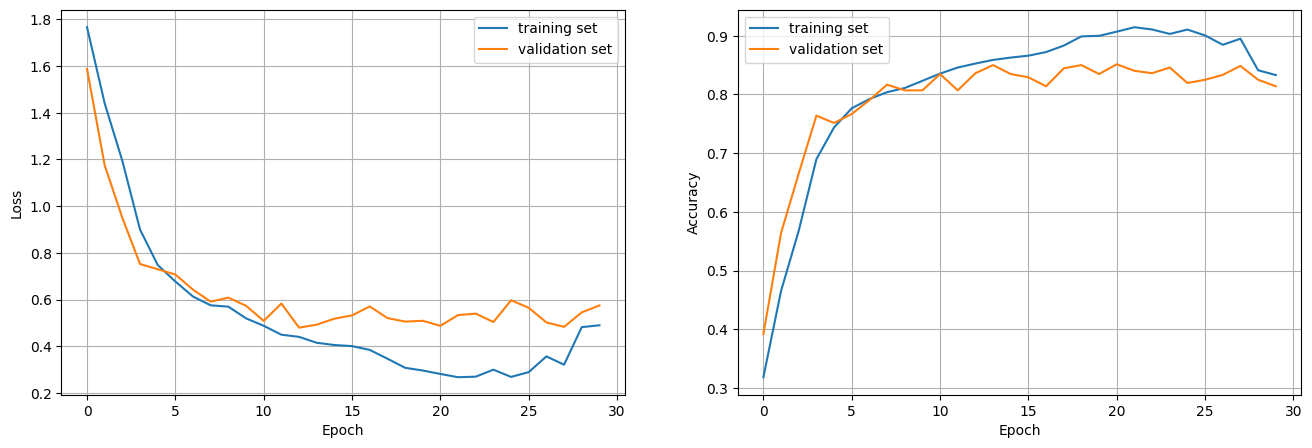

In [ ]:
# Save multiple graphs to show training
def plot_training_history(training_info):
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['accuracy'], label="training set")
    axs[1].plot(training_info.history['val_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

# Overfitting because training set accuracy is moving towards 1, however it is not terrible, as val accuracy is still improving
# Overfitting towards dataset?
# What is our data? How does this graph represent that?

---
(b) Comment on the above plots w.r.t. the accuracy on the task, sufficiency of the training process, any possible recommendations to change the model or training regime?

In [ ]:
#(b)
# Could be possible to increase val w/ more epochs
# Slight overfitting, but val accuracy has not negatively impacted, yet

(c) Evaluate the model on the test set and comment on the result.

In [ ]:
#(c)
train_loss, train_accuracy = model.evaluate(Xtrain_norm, ytrain, verbose=0)
test_loss, test_accuracy = model.evaluate(Xtest_norm, ytest, verbose=0)

print("TRAIN SET ACCURACY:", train_accuracy, sep="\t")
print("TEST SET ACCURACY:", test_accuracy, sep="\t")

# Pretty good accuracy w/ small training data, simple network, etc.

TRAIN SET ACCURACY:	0.8536111116409302
TEST SET ACCURACY:	0.8137500286102295


---
The general analysis above is useful to determine the success of the learning process and to troubleshoot model and training parameters. However, we would like to examine the **nature of errors for our task**. Doing this may help us to find more specific or systematic issues that need to be addressed, for example, with our configuration of acoustic feature extraction.

For classification tasks, inspecting the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is often the next step.

(d) Show the confusion matrix for the test set samples.

**Hint:** You can use `pandas` or the example provided in the Tensorflow tutorial mentioned earlier, the relevant steps [start here](https://www.tensorflow.org/tutorials/audio/simple_audio#evaluate_the_model_performance).

In [ ]:
#(d)
# Check confusion matrices code from answers

---
(e) Interpret and comment on the confusion matrix

In [ ]:
#(e)
# ANSWER

---
Once we are satisfied that the model is working on our carefully prepared data, let's apply it in practice.

Use the following code ([ref](https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be)) to record a short (1 second) audio clip saying one of the words in the vocabulary

Listen to the recording and try again until the timing is right.

In [ ]:
for i in range(3):
  print(f"Recording in {3-i}...")
  time.sleep(1)
print("RECORDING...")
my_audio = record().split_to_mono()
print("DONE!")
print("Listen to your recording:")
my_audio[0]

---
Convert your audio to MFCC features, normalize and classify using the model:

In [ ]:
# Extract and convert audio samples to the format expected by librosa:
my_audio_samples = np.array(my_audio[0].get_array_of_samples()) / (2 ** (my_audio[0].sample_width * 8 - 1))
my_audio_samples = librosa.resample(my_audio_samples, orig_sr=my_audio[0].frame_rate, target_sr=16000)

# Extract features, place in array of correct shape for the model and normalize
my_padded_mfccs = extract_features(my_audio_samples)
my_input = my_padded_mfccs.T.reshape((1, *Xtrain.shape[1:]))
my_input_norm = znorm(my_input, train_means, train_stds)

# Classify and print result
my_result = model.predict(my_input_norm)
for word, prob in zip(words, my_result.flatten()):
  print(word, prob, sep="\t")

---
(f) Comment on the results you are getting, is it as you expected? Why not?

In [ ]:
#(f)
# ANSWER

---
(g) Experiment with different network configurations and amounts of training. Some things you might try:
 - Change to GRU units
 - Add a second Bidirectional layer

What is the best performance you can obtain on the test set?